In [1]:
from numpythia import Pythia, STATUS, HAS_END_VERTEX, ABS_PDG_ID
from pyjet import cluster

%matplotlib inline

import matplotlib.pyplot as plt
import numpy as np
import pandas as pd

import ROOT

Welcome to JupyROOT 6.14/04


In [2]:
#in selection do not allow it to be a neutrino
selection = ((STATUS == 1) & ~HAS_END_VERTEX & (ABS_PDG_ID != 12) & (ABS_PDG_ID != 14) & (ABS_PDG_ID != 16))

In [3]:
params = {
 "HardQCD:all":          "on",  #hard subprocesses (2->2) are considered
 "Beams:eCM":            100,   #center of mass energy
 "Beams:idA":            11,    #identity of incoming object A in the collision
 "Beams:idB":            2212,  #identity of incoming object B in the collision
 "PDF:lepton2gamma":     "on",  #initial state radiation for leptons 
 "Photon:Q2max":         1.0,   #upper limit for real photon virtuality (can only handle (quasi-)real photons)
 "Photon:Wmin":          10.0,  #minimum for the invariant mass (total energy and momentum) of a photon-hadron system
 "PhaseSpace:pTHatMin":  2.0,   #minimum pT 
 "PhotonParton:all":     "on",  #photon-parton interactions (gmg->qqbar,ccbar,ddbar)
 "Photon:ProcessType":   0,     #mixed contributions from resolved and direct photon interactions (resolved=hadronic photon behavior)
 "Main:timesAllowErrors":10000, #allowed number of errors before aborting
}

In [3]:
#DIS process

params = {
 "Beams:frameType":                2,    #set-up frame for beams with unequal energies
 "Beams:idA":                      2212, #identity of incoming object A in the collision (p)
 "Beams:idB":                      11,   #identity of incoming object B in the collision (e)
 "Beams:eA" :                      250,  #beam energy of incoming object A in the collision
 "Beams:eB"  :                     20,   #beam energy of incoming object B in the collision
    
 #Set up DIS process within some phase space.
    
 "WeakBosonExchange:ff2ff(t:gmZ)": "on", #turn on neutral currents (with gamma/Z interference)
 "PhaseSpace:Q2Min":               10,   #minimum for real photon virtuality (phase space cut)
 "SpaceShower:pTmaxMatch":         2,    #always allow emissions up to the kinematical limit
 "PDF:lepton":                     "off",#turn off QED radiation from lepton (lepton carries the full beam energy)
 "TimeShower:QEDshowerByL":        "off",#don't allow leptons to radiate photons
}

In [4]:
pythia = Pythia(params = params)


 *-------  PYTHIA Process Initialization  --------------------------*
 |                                                                  |
 | We collide p+ with e- at a CM energy of 1.414e+02 GeV            |
 |                                                                  |
 |------------------------------------------------------------------|
 |                                                    |             |
 | Subprocess                                    Code |   Estimated |
 |                                                    |    max (mb) |
 |                                                    |             |
 |------------------------------------------------------------------|
 |                                                    |             |
 | f f' -> f f' (t-channel gamma*/Z0)             211 |   1.896e-04 |
 |                                                                  |
 *-------  End PYTHIA Process Initialization -----------------------*

 *-------  PYTHIA 

Output dtype = [(′E′,′f8′),(′px′,′f8′),(′py′,′f8′),(′pz′,′f8′),(′mass′,′f8′),(′prodx′,′f8′),(′prody′,′f8′),(′prodz′,′f8′),(′prodt′,′f8′),(′pdgid′,′i4′),(′status′,′i4′)]

In [9]:
#proton and electron identification

j = 0
k = 0
l = 0

eIn_pt   = [0]*10000
eIn_p    = [0]*10000

eIn_4vec = [0]*10000

p_pt     = [0]*10000
p_p      = [0]*10000
p_eta    = [0]*10000

p_4vec   = [0]*10000

eOut_pt  = [0]*10000
eOut_p   = [0]*10000
eOut_eta = [0]*10000

eOut_4vec= [0]*10000

for event in pythia(events=1000):
    if not event: continue
    
    for i in event.all():
        
        if i['pdgid'] == 11 and i['status'] == 4:
            eIn_pt[j]  = np.sqrt(i['px']*i['px'] + i['py']*i['py'])
            eIn_p[j]   = np.sqrt(i['px']*i['px'] + i['py']*i['py'] + i['pz']*i['pz'])
            
            #make its respective 4 vector which can be used, along with the others, to find Q2, W, x_borj, and y
            eIn_4vec[j] = [i['px'],i['py'],i['pz'],i['E']]
            
            j = j  + 1
            
        if i['pdgid'] == 2212:
            p_pt[k]    = np.sqrt(i['px']*i['px'] + i['py']*i['py'])
            p_p[k]     = np.sqrt(i['px']*i['px'] + i['py']*i['py'] + i['pz']*i['pz'])
            p_eta[k]   = 0.5*np.log((p_p[k] + i['pz'])/(p_p[k] - i['pz']))
            
            p_4vec[k] = [i['px'],i['py'],i['pz'],i['E']]
        
            k = k  + 1
            
        if i['pdgid'] == 11 and i['status'] == 1:
            eOut_pt[l] = np.sqrt(i['px']*i['px'] + i['py']*i['py'])
            eOut_p[l]  = np.sqrt(i['px']*i['px'] + i['py']*i['py'] + i['pz']*i['pz'])
            eOut_eta[l]= 0.5*np.log((eOut_p[l] + i['pz'])/(eOut_p[l] - i['pz']))
            
            eOut_4vec[l] = [i['px'],i['py'],i['pz'],i['E']]
        
            l = l  + 1

electron_dataframe = pd.DataFrame({'eIn_pt': eIn_pt, 'eOut_pt': eOut_pt, 'eIn_p': eIn_p, 'eOut_p': eOut_p, 
                                   'eOut_eta': eOut_eta})

electron_data      = electron_dataframe.query('eIn_pt != 0')

proton_dataframe = pd.DataFrame({'p_pt': p_pt, 'p_p': p_p, 'p_eta': p_eta})
proton_data      = proton_dataframe.query('p_pt != 0')

/Users/jose/Library/Python/2.7/lib/python/site-packages/ipykernel_launcher.py:41: RuntimeWarning: divide by zero encountered in double_scalars



 Pythia::next(): 3000 events have been generated 

 *-------  PYTHIA Event and Cross Section Statistics  -------------------------------------------------------------*
 |                                                                                                                 |
 | Subprocess                                    Code |            Number of events       |      sigma +- delta    |
 |                                                    |       Tried   Selected   Accepted |     (estimated) (mb)   |
 |                                                    |                                   |                        |
 |-----------------------------------------------------------------------------------------------------------------|
 |                                                    |                                   |                        |
 | f f' -> f f' (t-channel gamma*/Z0)             211 |       11235       4000       4000 |   6.854e-05  6.057e-07 |
 |          

In [31]:
#pion identification

j = 0

ptArray  = [0]*10000
pArray   = [0]*10000
etaArray = [0]*10000

for event in pythia(events=1000):
    if not event: continue
    
    #PDG_ID == 211 corresponds to a pion with positive charge
    for i in event.all(selection & (ABS_PDG_ID == 211)):
        
        ptArray[j]  = np.sqrt(i['px']*i['px'] + i['py']*i['py'])
        pArray[j]   = np.sqrt(i['px']*i['px'] + i['py']*i['py'] + i['pz']*i['pz'])
        etaArray[j] = 0.5*np.log((pArray[j] + i['pz'])/(pArray[j] - i['pz']))
        
        j = j  + 1

pion_dataframe = pd.DataFrame({'pion_pt': ptArray, 'pion_p': pArray, 'pion_eta': etaArray})
pion_data      = pion_dataframe.query('pion_pt != 0')


 Pythia::next(): 12000 events have been generated 

 *-------  PYTHIA Event and Cross Section Statistics  -------------------------------------------------------------*
 |                                                                                                                 |
 | Subprocess                                    Code |            Number of events       |      sigma +- delta    |
 |                                                    |       Tried   Selected   Accepted |     (estimated) (mb)   |
 |                                                    |                                   |                        |
 |-----------------------------------------------------------------------------------------------------------------|
 |                                                    |                                   |                        |
 | f f' -> f f' (t-channel gamma*/Z0)             211 |       33114      12097      12097 |   6.916e-05  3.525e-07 |
 |         

In [8]:
j = 0

arrayJets_pt   = [0]*100000
arrayJets_eta  = [0]*100000
arrayJets_phi  = [0]*100000
arrayJets_mass = [0]*100000

for event in pythia(events=1000):
    if not event: continue
            
    jets = cluster(event.all(selection), R=1, p=-1, ep=True).inclusive_jets()
    
    for k in jets:
        
        arrayJets_pt[j]   = k.pt
        arrayJets_eta[j]  = k.eta
        arrayJets_phi[j]  = k.phi
        arrayJets_mass[j] = k.mass

        j = j + 1 
        
jets_dataframe = pd.DataFrame({'jet_pt': arrayJets_pt, 'jet_eta': arrayJets_eta, 'jet_phi': arrayJets_phi, 'jet_mass': arrayJets_mass})
jets_data      = jets_dataframe.query('jet_pt != 0')


 Pythia::next(): 2000 events have been generated 

 *-------  PYTHIA Event and Cross Section Statistics  -------------------------------------------------------------*
 |                                                                                                                 |
 | Subprocess                                    Code |            Number of events       |      sigma +- delta    |
 |                                                    |       Tried   Selected   Accepted |     (estimated) (mb)   |
 |                                                    |                                   |                        |
 |-----------------------------------------------------------------------------------------------------------------|
 |                                                    |                                   |                        |
 | f f' -> f f' (t-channel gamma*/Z0)             211 |        5496       2001       2001 |   6.826e-05  8.554e-07 |
 |          

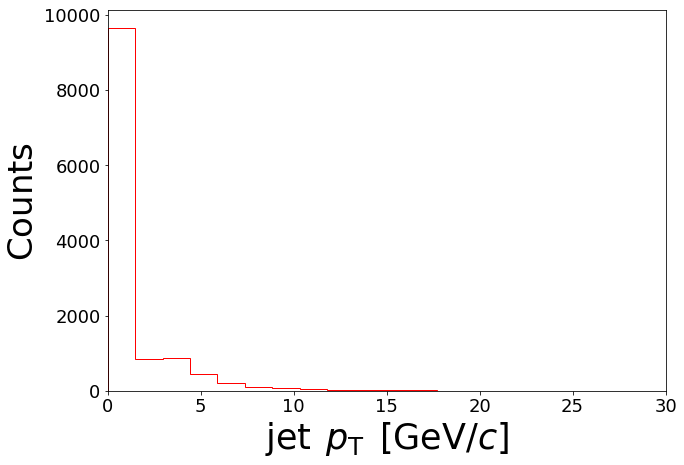

In [9]:
fig = plt.figure(figsize=(10,7))

plt.hist(jets_data['jet_pt'],bins =20,histtype='step',color='red')
plt.xlabel(r'$\mathrm{jet} \:\: p_\mathrm{T} \:\: [\mathrm{GeV}/c]$', fontsize = 35)
plt.xticks(fontsize = 18)
plt.xlim(0,30)
plt.ylabel(r'$\mathrm{Counts}$', fontsize = 34)
plt.yticks(fontsize =18)
plt.legend(loc='upper right', frameon=False, prop={'size':26})
plt.show()

In [ ]:
#how I was doing it before

# arrayArb = [0]*event.all().shape[0]

# def getData(array, variable):
#     for i in range(0, event.all().shape[0]):
#         array[i] = event.all()[i][variable]
#     return array

# pxArray = getData(arrayArb, 1)
# pyArray = getData(arrayArb, 2)

# ptArray = np.sqrt(np.power(pxArray,2) + np.power(pyArray,2))